In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn


## Creating the Training Data

In [40]:
Nx = 200 # Number of space points
# cfl =0.2
tmax = 1 # time 0 ~ 1

# viscosity_coeff = (0.01/math.pi)
viscosity_coeff = 0.02

x = np.linspace(-1,1, 200)

# t = 0, I.C.
u = -np.sin(math.pi * x)
dx = abs(x[1] - x[0])

dt = 0.002 # cfl * dx / np.max(np.abs(u))

nt = int(tmax/ dt) # number of time points

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(f"nt = ", nt)
print(f"dt = {dt}s")
print(f"tmax = {nt * dt}s")


nt =  500
dt = 0.002s
tmax = 1.0s


In [41]:
def f(u):
    y = 0.5 * u**2
    yp = u
    return y, yp

In [42]:
def minmod(a, b):
    return 0.5 * (np.sign(a) + np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [43]:
def RHS(u, dx, viscosity_coeff):
    #diffusion term
    diffusion_term = viscosity_coeff * (np.roll(u,1)- 2*u + np.roll(u,-1))/ dx**2
    
    ux = minmod((u - np.roll(u,1))/dx ,  (np.roll(u,-1) - u)/dx)
    
    uL = np.roll(u - 0.5 * dx*ux, 1)
    uR = u - 0.5 * dx * ux
    fL, fpL = f(uL)
    fR, fpR = f(uR)
    a = np.maximum(np.abs(fpL), np.abs(fpR))
    
    H = 0.5 * (fL + fR - a * (uR - uL))
    
    conv_term = -(np.roll(H, -1)-H)/dx
    
    y = conv_term + diffusion_term
    return y
    
    
    
    

In [44]:
for i in range(1, nt):
    u1 = u + dt * RHS(u, dx, viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx, viscosity_coeff))
    uf[i, :] = u

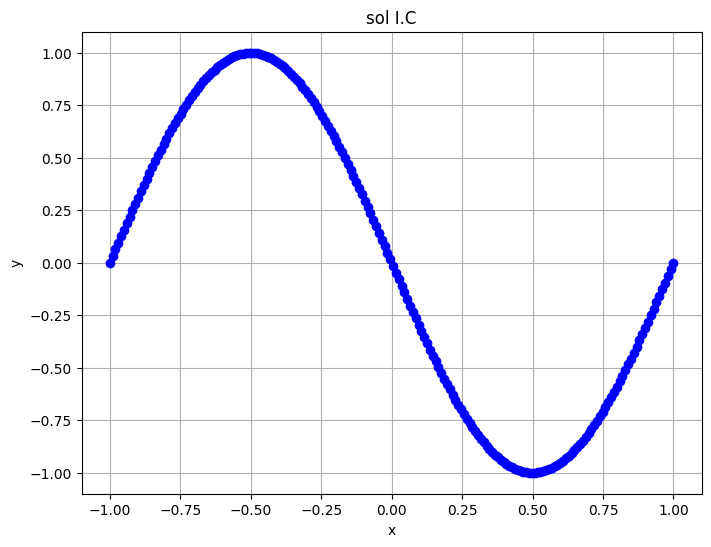

In [45]:
plt.figure(figsize = (8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

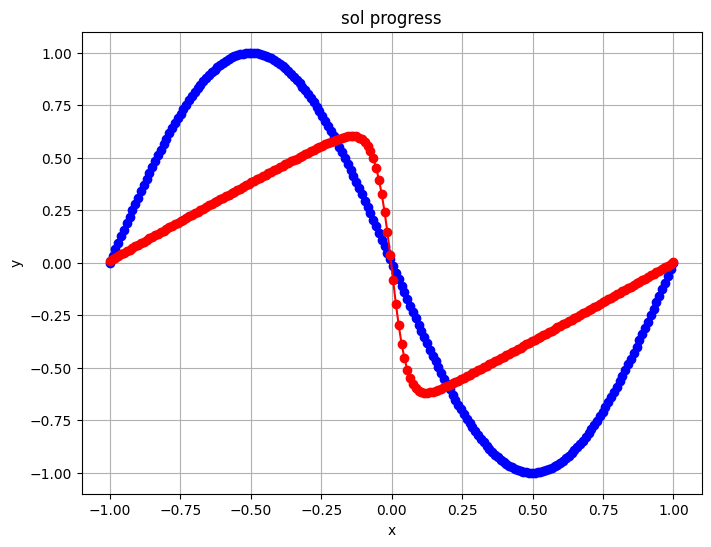

In [46]:
plt.figure(figsize = (8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol progress")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [47]:
tf = np.linspace(0, 1, nt)
xf = x

In [48]:
tf_tensor = torch.tensor(tf)
xf_tensor = torch.tensor(xf)

combined_tensor_x_train = torch.empty((len(tf) * len (xf), 2), dtype = torch.float32)

index = 0
for i in range(len(tf)):
    for j in range(len(xf)):
        combined_tensor_x_train[index][0] = xf_tensor[j]
        combined_tensor_x_train[index][1] = tf_tensor[i]
        index = index + 1

combined_tensor_x_train

tensor([[-1.0000,  0.0000],
        [-0.9899,  0.0000],
        [-0.9799,  0.0000],
        ...,
        [ 0.9799,  1.0000],
        [ 0.9899,  1.0000],
        [ 1.0000,  1.0000]])

In [49]:
len(combined_tensor_x_train)

100000

In [50]:
your_tensor = torch.tensor(uf, dtype = torch.float32)

flattened_tensor_y_train = your_tensor.view(-1)
flattened_tensor_y_train = flattened_tensor_y_train.unsqueeze(1)
flattened_tensor_y_train

tensor([[ 1.2246e-16],
        [ 3.1569e-02],
        [ 6.3106e-02],
        ...,
        [-1.4358e-02],
        [-6.6555e-03],
        [ 1.0607e-03]])

In [51]:
len(flattened_tensor_y_train)

100000

# Defining the Neural Network

In [64]:
lambda_value = 2.0
print("the real value = ", viscosity_coeff, "           our I-PINNs value = ", lambda_value)


the real value =  0.02            our I-PINNs value =  2.0


In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
            nn.Tanh()
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

In [67]:
class Net:
    def __init__(self):
         
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.lambda_value = torch.tensor([lambda_value], requires_grad = True).float().to(device)
        
        self.lambda_value = nn.Parameter(self.lambda_value)
        
        self.model = NN().to(device)
        
        self.model.register_parameter('lambda_value', self.lambda_value)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # ------------------ Input Data ------------------#
        self.X_train = combined_tensor_x_train
        self.y_train = flattened_tensor_y_train
        # ------------------------------------------------#
        
        self.X = self.X.to(device)
        self.X.requires_grad = True
        
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        
        # Optimizer
        self.adam = torch.optim.Adam(self.model.parameters())
        
        self.criterion = torch.nn.MSELoss()
        
        self.iter = 1
        
        
    # --------------- Loss Function --------------- #
    def loss_func(self):
        self.adam.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
            
        )[0]
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        lambda_pde = self.lambda_value
        
        loss_pde = self.criterion(du_dt + 1 * u.squeeze() * du_dx, lambda_pde * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print("iteration number = ", self.iter, "  loss value = ", loss.item(), "real mu = ", viscosity_coeff,  "IPINN lambda = ", self.lambda_value.item() )
    
        
        self.iter = self.iter + 1
        
        return loss
    
    def train(self):
        self.model.train()
        
        for i in range(5000):
            self.adam.step(self.loss_func)
            
    def eval(self):
        self.model.eval()
            

In [69]:
net = Net()
net.train()
net.model.eval()


iteration number =  100   loss value =  0.19765114784240723 real mu =  0.02 IPINN lambda =  1.9483755826950073
iteration number =  200   loss value =  0.18840160965919495 real mu =  0.02 IPINN lambda =  1.9050697088241577
iteration number =  300   loss value =  0.16120359301567078 real mu =  0.02 IPINN lambda =  1.8105379343032837
iteration number =  400   loss value =  0.15772408246994019 real mu =  0.02 IPINN lambda =  1.691315770149231
iteration number =  500   loss value =  0.15472690761089325 real mu =  0.02 IPINN lambda =  1.566547155380249
iteration number =  600   loss value =  0.15224553644657135 real mu =  0.02 IPINN lambda =  1.4321717023849487
iteration number =  700   loss value =  0.14947828650474548 real mu =  0.02 IPINN lambda =  1.287183165550232
iteration number =  800   loss value =  0.1458723396062851 real mu =  0.02 IPINN lambda =  1.1294258832931519
iteration number =  900   loss value =  0.14075574278831482 real mu =  0.02 IPINN lambda =  0.9582433104515076
itera

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

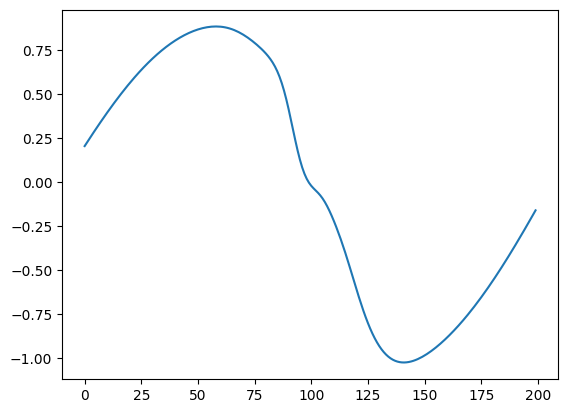

In [70]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()
y_pred_inverse = y_pred
#I.C
plt.plot(y_pred_inverse[:,0])

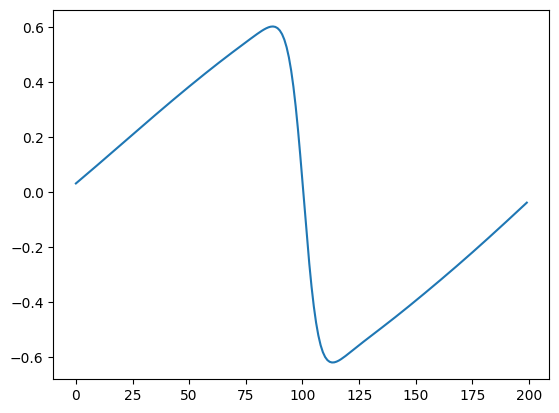

In [71]:
#I.C
plt.plot(y_pred_inverse[:,-1])

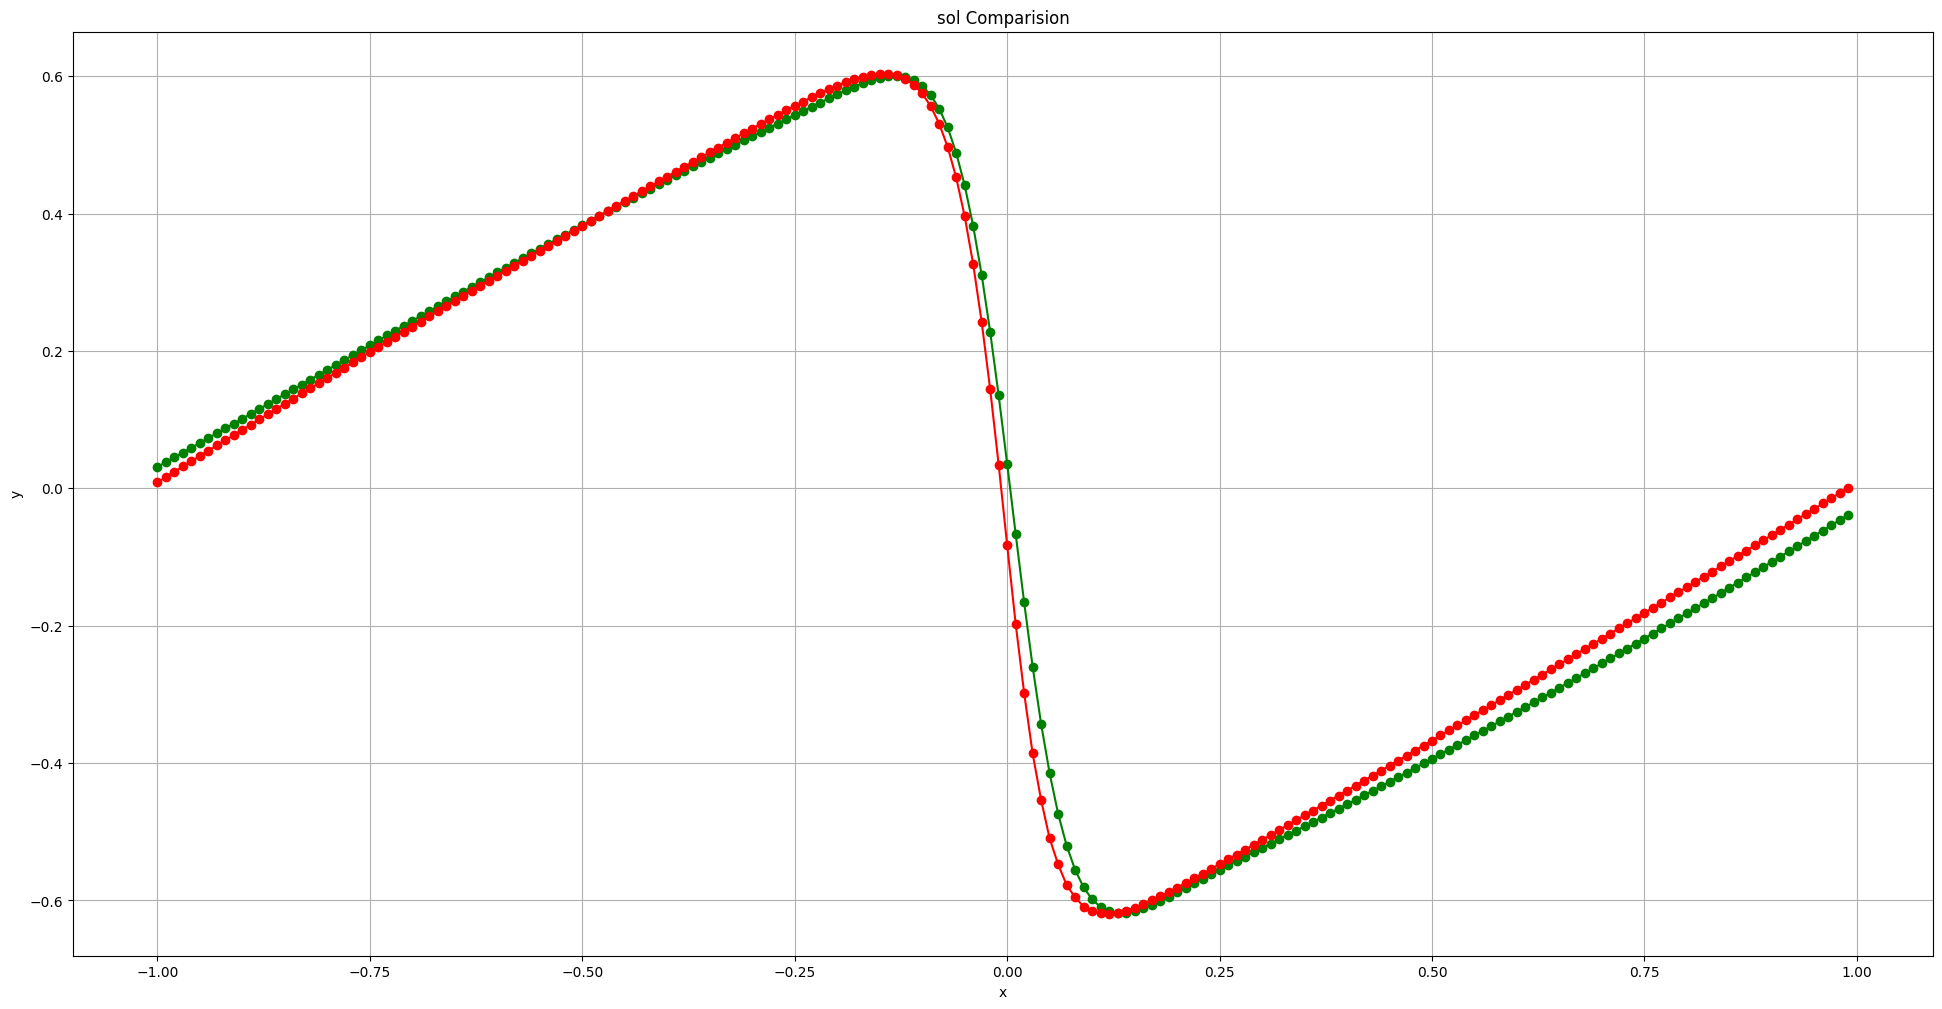

In [72]:
plt.figure(figsize=(24,12))
plt.plot(x, y_pred_inverse[:,-1], '-o', color = 'g') #IPINNs
plt.plot(x, uf[-1], '-o', color = 'r') #TVD
plt.title("sol Comparision")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [73]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred_inverse, cmap='jet')

<Axes: >